In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import os.path as osp
import pandas as pd
import numpy as np
import fire
import pickle
import time

from typing import List
from dataclasses import dataclass
from tqdm import tqdm
from functools import partial
from sentence_transformers import SentenceTransformer

from decoding import naive_decoding, dpp_decoding
from models.mistral import Mistral
from metrics import compute_metrics, ResultCollector
from visualize import plot

/home/nhb25/.conda/envs/dsl/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
def preprocess_rocstories(df, max_samples=1000):
    STORY_GEN_TEMPLATE = "<s>[INST] Complete the last two sentences of the following story.[/INST] Title: {}\nStory: {}\nLast two sentences:"
    sample_df = df.sample(max_samples)
    data = []
    for index, row in sample_df.iterrows():
        title = row['storytitle']
        story = row['sentence1'] + ' ' + row['sentence2'] + ' ' + row['sentence3']
        prompt = STORY_GEN_TEMPLATE.format(title, story)
        data.append({
            'prompt': prompt,
            'completion': row['sentence4'] + ' ' + row['sentence5']
        })
    return data

def load_rocstories(max_samples=1000):
    df = pd.read_csv('datasets/ROCStories/dataset_2017.csv')
    dataset = preprocess_rocstories(df, max_samples=max_samples)
    return dataset

language_model = Mistral()
embedding_model = SentenceTransformer('all-mpnet-base-v2')
dataset = load_rocstories(max_samples=10)

Loading checkpoint shards: 100%|██████████| 3/3 [00:06<00:00,  2.25s/it]


In [9]:
from dpp import map_inference_dpp_greedy, map_inference_dpp_local_search_2, dpp_sampling
from metrics import ResultCollector

def dpp_decoding(prompt, language_model, embedding_model, k, method='sampling', n=100, kernel_width=50, gamma=0.1, temperature=0.5):
    output = language_model(
        prompt,
        temperature=temperature,
        num_samples=n,
    )
    embeddings = embedding_model.encode(output['generated_text'])
    log_probs = output['logprobs']
    D = np.diag(np.exp(- log_probs ** 2 / kernel_width ** 2))
    S = (embeddings @ embeddings.T) / (np.linalg.norm(embeddings, axis=1) * np.linalg.norm(embeddings, axis=1).T)
    L = gamma * S + (1 - gamma) * D

    ls_S, ls_obj, ls_time, greedy_S, greedy_obj, greedy_time = map_inference_dpp_local_search_2(L, k)
    return {
        "ls_obj": ls_obj,
        "ls_time": ls_time,
        "greedy_obj": greedy_obj,
        "greedy_time": greedy_time,
    }


param_to_vary = {
    'name': 'gamma',
    'min': 0.001,
    'max': 1.1,
    'step': 0.2
}
dpp_params = {
    'n': 50,
}
    
rescol = ResultCollector()
for k in range(2, 6):
    sample_rescol = ResultCollector()
    for sample in dataset:
        prompt = sample['prompt']
        out = dpp_decoding(prompt, language_model, embedding_model, k, **dpp_params)
        sample_rescol.add(out)
    
    print(sample_rescol.get_summarized_results())
    rescol.add(sample_rescol.get_summarized_results())

print(rescol.get_summarized_results())

{'ls_obj': 0.9562438726425171, 'ls_time': 0.0007222175598144531, 'greedy_obj': 0.8984600305557251, 'greedy_time': 0.00010824203491210938}
{'ls_obj': 0.8863435983657837, 'ls_time': 0.0007379770278930664, 'greedy_obj': 0.8047146797180176, 'greedy_time': 0.00012543201446533204}
{'ls_obj': 0.798147976398468, 'ls_time': 0.0007527828216552735, 'greedy_obj': 0.721917986869812, 'greedy_time': 0.0001333475112915039}
{'ls_obj': 0.738888680934906, 'ls_time': 0.0007527828216552735, 'greedy_obj': 0.6590461134910583, 'greedy_time': 0.00013964176177978517}
{'ls_obj': 0.8449060320854187, 'ls_time': 0.0007414400577545166, 'greedy_obj': 0.7710347026586533, 'greedy_time': 0.00012666583061218264}


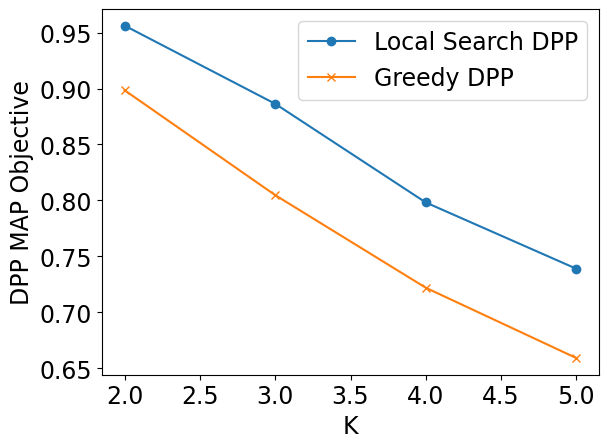

In [17]:
from matplotlib import pyplot as plt
save_path = "results/greedy_vs_ls_obj.png"

plt.rcParams.update({'font.size': 17})
x = list(range(2, 6))
fig, ax = plt.subplots()


df = rescol.get_df()
ax.plot(x, df["ls_obj"].to_numpy(), label="Local Search DPP", marker='o')
ax.plot(x, df["greedy_obj"].to_numpy(), label="Greedy DPP", marker='x')

ax.set_xlabel("K")
ax.set_ylabel("DPP MAP Objective")

ax.legend()

plt.tight_layout()
plt.savefig(save_path, dpi=400)

plt.show()


In [26]:
r, N, k = 50, 10, 20

N_list = [100, 200, 500, 1000, 2000]
greedy_times = []
ls_times = []
for N in N_list:
    Phi = np.random.randn(r, N)
    L = Phi.T.dot(Phi)
    ls_S, ls_obj, ls_time, greedy_S, greedy_obj, greedy_time = map_inference_dpp_local_search_2(L, k)
    greedy_times.append(greedy_time)
    ls_times.append(ls_time)

In [27]:
greedy_times

[0.0002598762512207031,
 0.00022983551025390625,
 0.0002465248107910156,
 0.0003025531768798828,
 0.00045371055603027344]

In [28]:
ls_times

[0.001493692398071289,
 0.002503633499145508,
 0.006397247314453125,
 0.010947227478027344,
 0.02184128761291504]

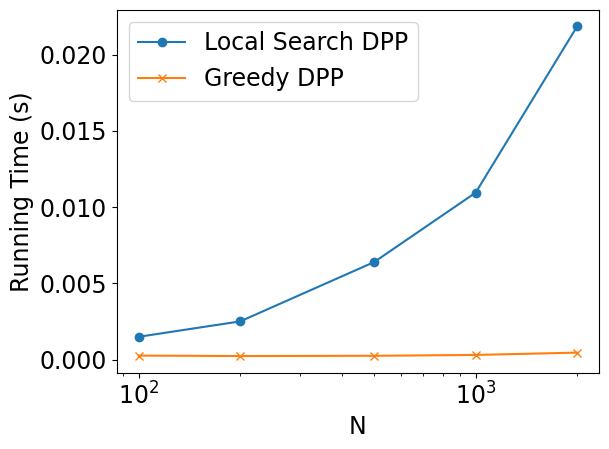

In [29]:
from matplotlib import pyplot as plt
save_path = "results/greedy_vs_ls_time.png"

plt.rcParams.update({'font.size': 17})
x = np.array(N_list)

fig, ax = plt.subplots()


df = rescol.get_df()
ax.plot(x, ls_times, label="Local Search DPP", marker='o')
ax.plot(x, greedy_times, label="Greedy DPP", marker='x')

ax.set_xscale('log')
ax.set_xlabel("N")
ax.set_ylabel("Running Time (s)")

ax.legend()

plt.tight_layout()
plt.savefig(save_path, dpi=400)

plt.show()